In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import tt

def assemble_solve_SimplePDE(coeff, linear_system=True):
  """
  Solve simple diffusion problem on [0,1] using P1 finite elements.
  """

  [num_coeff, nx, I] = np.shape(coeff[0])

  coeff = coeff[0][0,:,:]

  if np.min(coeff) <= 0:
    warnings.warn(f'Non positive components')
  
  A = [[None] * I for i in range(2)]
  F = [[None] * I for i in range(2)]
  U = []

  for i in range(I):
    # constant part
    Fi1 = np.full((nx+1,1), 10/(nx)) # assume RHS = 1 
    Fi1[[0,-1]] = 0 # boundary condition
    # part dependent on coeff (0 here)
    Fi0 = np.zeros((nx+1,1))
    F[0][i], F[1][i] = Fi0, Fi1
    
    # assemble A, coeff piecewise constant on grid
    # first part linearly dependent on coeff
    Ai0 = np.zeros((nx+1,nx+1))
    Ai0.flat[nx+2::nx+2] = (coeff[1:,i] + coeff[:-1, i]) * nx # set diag
    Ai0.flat[1::nx+2] = -coeff[:,i] * nx # set first upper diag
    Ai0.flat[nx+1::nx+2] = -coeff[:,i] * nx # set first lower diag
    Ai0[[0,-1]] = 0
    A[0][i] = Ai0
    
    # constant part (from boundary condition)
    Ai1 = np.zeros((nx+1,nx+1))
    Ai1[0,0] = 1
    Ai1[-1,-1] = 1
    A[1][i] = Ai1

    U.append(np.linalg.solve(Ai0 + Ai1, Fi0 + Fi1).reshape((-1,1)))
  
  if linear_system:
    return U,A,F
  else:
    return U


def coeff(X, Nx, Ny, offset, var):
  c = np.full(len(X), offset,dtype=float)
  for i, x in enumerate(X):
    # print(i)
    for k in range(1, len(x)):
      c[i] += np.exp(-k) * np.sin(np.pi*k*x[0]/(Nx-1)) * (x[k]/(Ny-1) - 0.5) * var
  return c

### PDE test

Solve the PDE using P1 finite elements for a random parameter

Text(0, 0.5, 'A')

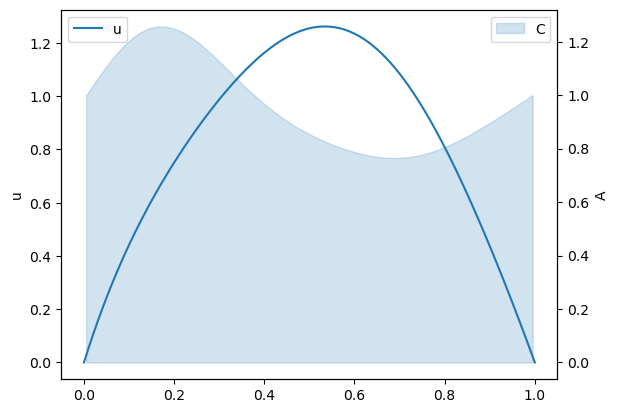

In [2]:
Nx = 100      # spatial resolution
Ny = 10       # parameter resolution
n_param = 5   # number of parameters
offset = 1   # parameter mean
var = 4       # 'variance' of the parameters

# get random params
y = np.random.randint(0,Ny, n_param)
X = np.hstack([np.arange(Nx).reshape((-1,1)), np.tile(y, [Nx,1])])

cfun = lambda x : coeff(x, Nx, Ny, offset, var)

C_true = cfun(X)

U,A,F = assemble_solve_SimplePDE([C_true.reshape(1,-1,1), np.ones((1,1,1))])
U = np.ravel(U[0])

fig, ax = plt.subplots()
ax2 = ax.twinx()

x = np.arange(Nx+1) / Nx
midpoints = (np.arange(Nx) + 0.5) / Nx
p = ax.plot(x, U, label='u')
ax2.fill_between((np.arange(len(C_true)) + 0.5) / (len(C_true)), C_true, alpha=0.2, color=p[0].get_color(), label='C')

ax.set_ylabel('u')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylabel('A')

### Get TT approx of coefficient

In [3]:
from tt import cross

# random init tensor
C = tt.rand(np.array([Nx] + [Ny] * n_param),r=3)
# compute TT approx using TT-cross
C = tt.cross.rect_cross.cross(cfun, C, eps = 1e-8, kickrank=1)
C = C.round(1e-12)

print("Coefficient ranks: ", C.r)
print("Coefficient dims: ", C.n)

swp: 0/9 er_rel = 1.1e+01 er_abs = 3.8e+04 erank = 5.0 fun_eval: 2160
swp: 1/9 er_rel = 2.8e-02 er_abs = 9.6e+01 erank = 9.1 fun_eval: 7300
swp: 2/9 er_rel = 1.3e-15 er_abs = 4.4e-12 erank = 13.9 fun_eval: 20240
Coefficient ranks:  [1 6 5 4 3 2 1]
Coefficient dims:  [100  10  10  10  10  10]


### Test TT approx

Compare TT approx of coefficient $A$ vs the true coefficient $A$ for the random parameter sample from above

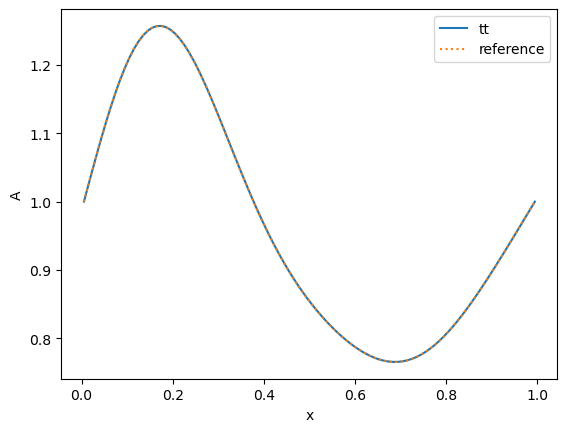

In [4]:
# eval TT-approx of coeff
C_eval = np.empty(Nx)
for i in range(Nx):
  C_eval[i] = C[np.concatenate((np.array([i]), y))]

fig, ax = plt.subplots()

x = (np.arange(0, Nx) + .5) / Nx
ax.plot(x, C_eval, label='tt')
ax.plot(x, C_true, ls='dotted', label="reference")
ax.set_xlabel('x')
ax.set_ylabel('A')
ax.legend()

In [5]:
# helper tensor that is filled with ones
cores = [np.ones((1,1,1))]
for i in range(n_param):
  cores += [np.ones((1,Ny,1))]

C_const = tt.vector.from_list(cores)

### ALS-cross test

In [6]:
from als_cross import als_cross

test = als_cross(
  [C, C_const], 
  assemble_solve_SimplePDE,
  1e-8,
  kickrank=0
  )

test.iterate(3)

print(test.get_stats())

= swp=1 core 0, max_dx=1.000e+00, max_rank = 6
= swp=1 core 1>, dx=1.000e+00, rank = [6, 5]
= swp=1 core 2>, dx=1.000e+00, rank = [5, 4]
= swp=1 core 3>, dx=1.000e+00, rank = [4, 3]
= swp=1 core 4>, dx=1.000e+00, rank = [3, 2]
= swp=1 fwd finish, max_dx=1.000e+00, max_rank = 6
= swp=2 core <5, dx=0.000e+00, rank = [2, 1]
= swp=2 core <4, dx=2.915e-16, rank = [3, 2]
= swp=2 core <3, dx=3.106e-04, rank = [4, 3]
= swp=2 core <2, dx=1.234e-03, rank = [5, 4]
= swp=2 core <1, dx=9.194e-03, rank = [6, 5]
= swp=3 core 0, max_dx=3.383e-02, max_rank = 6
= swp=3 core 1>, dx=1.980e-02, rank = [6, 5]
= swp=3 core 2>, dx=9.337e-03, rank = [5, 4]
= swp=3 core 3>, dx=1.403e-03, rank = [4, 3]
= swp=3 core 4>, dx=2.981e-04, rank = [3, 2]
= swp=3 fwd finish, max_dx=1.980e-02, max_rank = 6
{'t_solve': 0.001114034981583245, 't_project': 0.0003077470028074458, 'n_PDE_eval': 12}


### Test ALS-cross accuracy

Compare ALS cross approximation vs PDE solution for a random sample

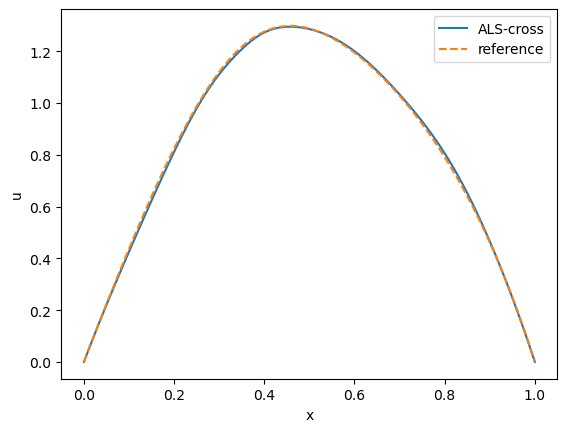

In [16]:
# get random parameter
y = np.random.randint(0,Ny, n_param)
X = np.hstack([np.arange(100).reshape((-1,1)), np.tile(y, [100,1])])

C_true = cfun(X) # compute true coeff

U,A,F = assemble_solve_SimplePDE([C_true.reshape(1,-1,1), np.zeros((1,1,1))]) # solve PDE
U = np.ravel(U)

# eval ALS-cross
u = test.get_tensor()
U_eval = np.empty(u.n[0])
for i in range(u.n[0]):
  U_eval[i] = u[np.concatenate((np.array([i]), y))]

fig, ax = plt.subplots()

x = np.arange(0, Nx+1) / Nx
ax.plot(x, U_eval, label='ALS-cross')
ax.plot(x, U, ls='dashed', label='reference')
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.legend()